### 概要
- validation を 0.2 にする
- 隠れ層も 1 つ消すわ --> bug ルカらやめるわ

### import modules

In [1]:
import cv2
import glob
import copy
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPool1D, GlobalAveragePooling1D
from keras.layers import Convolution2D, MaxPool2D
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.utils import np_utils

Using TensorFlow backend.
/Users/sakasaikeisuke/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/sakasaikeisuke/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/sakasaikeisuke/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 =

### input data

In [3]:
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')
train = train_data[['id', 'species']]
test = test_data[['id']]

### データの前処理

In [4]:
def resize_img_2d(img=np.array([]), end_size=100, show=False):
    max_ = np.maximum(img.shape[0], img.shape[1])
    scale = end_size / max_
    height, width = img.shape
    size = (int(width * scale), int(height * scale))

    rescale_img = cv2.resize(img, size, interpolation=cv2.INTER_CUBIC)
    height, width = rescale_img.shape

    if width > height:
        z_padding = np.zeros([int((width - height) / 2), width], dtype=np.uint8)
        resize_img = np.vstack((z_padding, rescale_img, z_padding))
    else:
        z_padding = np.zeros([height, int((height - width) / 2)], dtype=np.uint8)
        resize_img = np.hstack((z_padding, rescale_img, z_padding))

    resize_img = cv2.resize(resize_img, (end_size, end_size))
    resize_img2 = resize_img.reshape(-1,)

    if show == True: return resize_img
    else:

        return resize_img

In [5]:
# label_speacies の作成
all_label_list = train['species'].values
i = 0
label_species = {}
for label in all_label_list:
    if label in label_species: pass
    else:
        label_species['{}'.format(label)] = i
        i = i + 1
# label_species

In [6]:
end_size = 100
# x_train の作成
x_train = []
for _id in train['id']:
    img = np.array(Image.open('../input/images/{:.0f}.jpg'.format(_id)))
    x_train.append(resize_img_2d(img, end_size=end_size))
x_train = np.array(x_train)

In [7]:
# x_test の作成
x_test = []
for _id in test['id']:
    img = np.array(Image.open('../input/images/{:.0f}.jpg'.format(_id)))
    x_test.append(resize_img_2d(img, end_size=end_size))
x_test = np.array(x_test)

In [8]:
# t_train の作成
t_train = []
for _species in train['species']:
    _t_train = np.array([0] * 99)
    correct_label = label_species[_species]
    _t_train[correct_label] = 1
    t_train.append(_t_train)
t_train = np.array(t_train)

In [9]:
print('x_train', x_train.shape)
print('x_test', x_test.shape)
print('t_train', t_train.shape)
x_train_r = np.zeros((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_train_r[:, :, :, 0] = x_train
x_test_r = np.zeros((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
x_test_r[:, :, :, 0] = x_test
print('x_train_r', x_train_r.shape)
print('x_test_r', x_test_r.shape)

x_train (990, 100, 100)
x_test (594, 100, 100)
t_train (990, 99)
x_train_r (990, 100, 100, 1)
x_test_r (594, 100, 100, 1)


In [10]:
label_encoder = LabelEncoder().fit(train.species)
labels = label_encoder.transform(train.species)
classes = list(label_encoder.classes_)
nb_classes = len(classes)

### Cross validation (とりあえずやらん)

In [11]:
# sss = StratifiedShuffleSplit(test_size=0.1, random_state=23)
# for train_index, valid_index in sss.split(scaled_train, labels):
#     X_train, X_valid = scaled_train[train_index], scaled_train[valid_index]
#     y_train, y_valid = labels[train_index], labels[valid_index]
y_train = labels
y_train = np_utils.to_categorical(y_train, nb_classes)
print('y_train', y_train.shape)

y_train (990, 99)


### Conv2D の作成

In [12]:
model = Sequential()

model.add(Convolution2D(64, 3 , input_shape = (end_size, end_size , 1)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Convolution2D(32,3))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_classes, activation='softmax'))

adam = Adam(lr=1e-4)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

W0828 11:35:56.882067 4592674240 deprecation_wrapper.py:119] From /Users/sakasaikeisuke/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 11:35:56.933331 4592674240 deprecation_wrapper.py:119] From /Users/sakasaikeisuke/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 11:35:56.946055 4592674240 deprecation_wrapper.py:119] From /Users/sakasaikeisuke/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0828 11:35:57.003411 4592674240 deprecation_wrapper.py:119] From /Users/sakasaikeisuke/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/keras/backend/tensorfl

In [14]:
# sgd = SGD(lr=0.1, nesterov=True, decay=1e-6, momentum=0.9)
# model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

### 学習

In [15]:
nb_epoch = 200
model.fit(x_train_r, y_train, nb_epoch=nb_epoch, batch_size=16, validation_split=0.2)
model.save_weights('./models/param-Conv2D-img-2.hdf5')

W0828 11:36:11.458713 4592674240 deprecation.py:323] From /Users/sakasaikeisuke/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 792 samples, validate on 198 samples
Epoch 1/200
792/792 [==============================] - 18s 23ms/step - loss: 15.8498 - acc: 0.0152 - val_loss: 15.7169 - val_acc: 0.0202
Epoch 2/200
792/792 [==============================] - 16s 20ms/step - loss: 15.7726 - acc: 0.0189 - val_loss: 15.8737 - val_acc: 0.0152
Epoch 3/200
792/792 [==============================] - 16s 20ms/step - loss: 15.7805 - acc: 0.0202 - val_loss: 15.9553 - val_acc: 0.0101
Epoch 4/200
792/792 [==============================] - 16s 20ms/step - loss: 15.7518 - acc: 0.0227 - val_loss: 15.9553 - val_acc: 0.0101
Epoch 5/200
792/792 [==============================] - 16s 20ms/step - loss: 15.7518 - acc: 0.0227 - val_loss: 15.9553 - val_acc: 0.0101
Epoch 6/200
792/792 [==============================] - 16s 20ms/step - loss: 15.7638 - acc: 0.0215 - val_loss: 15.7925 - val_acc: 0.0202
Epoch 7/200
792/792 [==============================] - 16s 20ms/step - loss: 15.7594 - acc: 0.0202 - val_loss: 15.9553 - val_acc: 0.

792/792 [==============================] - 16s 20ms/step - loss: 0.0070 - acc: 0.9975 - val_loss: 2.0192 - val_acc: 0.5505
Epoch 61/200
792/792 [==============================] - 16s 20ms/step - loss: 0.0036 - acc: 1.0000 - val_loss: 2.0109 - val_acc: 0.5505
Epoch 62/200
792/792 [==============================] - 16s 20ms/step - loss: 0.0033 - acc: 1.0000 - val_loss: 2.0000 - val_acc: 0.5758
Epoch 63/200
792/792 [==============================] - 16s 20ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 2.0350 - val_acc: 0.5657
Epoch 64/200
792/792 [==============================] - 16s 20ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 2.0293 - val_acc: 0.5707
Epoch 65/200
792/792 [==============================] - 16s 20ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 2.0215 - val_acc: 0.5556
Epoch 66/200
792/792 [==============================] - 16s 20ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 1.9880 - val_acc: 0.5657
Epoch 67/200
792/792 [==============================] - 16s 2

792/792 [==============================] - 15s 19ms/step - loss: 0.0051 - acc: 0.9975 - val_loss: 2.3853 - val_acc: 0.5455
Epoch 122/200
792/792 [==============================] - 15s 19ms/step - loss: 0.0061 - acc: 0.9987 - val_loss: 2.3933 - val_acc: 0.5606
Epoch 123/200
792/792 [==============================] - 15s 19ms/step - loss: 0.0039 - acc: 1.0000 - val_loss: 2.2877 - val_acc: 0.5758
Epoch 124/200
792/792 [==============================] - 15s 19ms/step - loss: 0.0073 - acc: 0.9975 - val_loss: 2.3012 - val_acc: 0.5505
Epoch 125/200
792/792 [==============================] - 15s 20ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 2.3548 - val_acc: 0.5556
Epoch 126/200
792/792 [==============================] - 15s 19ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 2.2660 - val_acc: 0.5707
Epoch 127/200
792/792 [==============================] - 15s 19ms/step - loss: 0.0035 - acc: 1.0000 - val_loss: 2.3435 - val_acc: 0.5657
Epoch 128/200
792/792 [==============================] 

Epoch 180/200
792/792 [==============================] - 17s 21ms/step - loss: 0.0052 - acc: 0.9975 - val_loss: 2.3665 - val_acc: 0.5859
Epoch 181/200
792/792 [==============================] - 15s 19ms/step - loss: 0.0011 - acc: 0.9987 - val_loss: 2.3675 - val_acc: 0.5758
Epoch 182/200
792/792 [==============================] - 16s 20ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 2.3761 - val_acc: 0.5707
Epoch 183/200
792/792 [==============================] - 17s 21ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 2.3959 - val_acc: 0.5758
Epoch 184/200
792/792 [==============================] - 19s 24ms/step - loss: 0.0058 - acc: 0.9987 - val_loss: 2.3906 - val_acc: 0.5606
Epoch 185/200
792/792 [==============================] - 19s 23ms/step - loss: 0.0027 - acc: 0.9987 - val_loss: 2.3627 - val_acc: 0.5606
Epoch 186/200
792/792 [==============================] - 17s 22ms/step - loss: 0.0045 - acc: 0.9987 - val_loss: 2.5033 - val_acc: 0.5556
Epoch 187/200
792/792 [==================

### 可視化

Text(0.5,1,'Dense-1dimention')

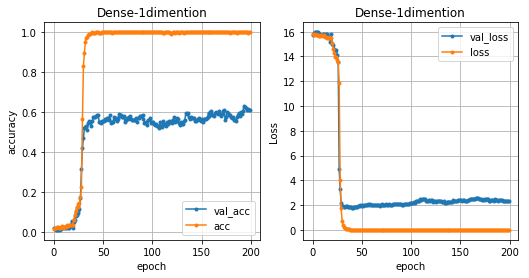

In [16]:
history = model.history
epoch = history.epoch
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
acc = history.history['acc']
loss = history.history['loss']

fig= plt.figure(figsize=(8.5, 4))
ax, ax_ = fig.add_subplot(121), fig.add_subplot(122)

# ax.plot([epoch[0], epoch[-1]] , [1, 1], 'k', ls='dashed', alpha=0.5)
ax.plot(epoch, val_acc, '.-', label='val_acc')
ax.plot(epoch, acc, '.-', label='acc')
ax_.plot(epoch, val_loss, '.-', label='val_loss')
ax_.plot(epoch, loss, '.-', label='loss')

ax.grid()
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('Dense-1dimention')

ax_.grid()
ax_.legend()
ax_.set_xlabel('epoch')
ax_.set_ylabel('Loss')
ax_.set_title('Dense-1dimention')

### predict

In [17]:
x_test_r = np.zeros((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
x_test_r[:, :, :, 0] = x_test
t_test = model.predict(x_test_r)
x_test_r.shape
t_test.shape

(594, 99)

---
id = 1129
label = Quercus_Shumardii


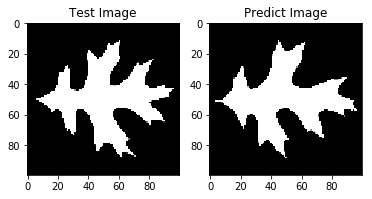

---
id = 731
label = Quercus_Crassifolia


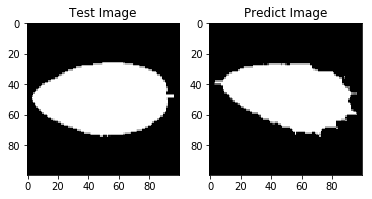

---
id = 1069
label = Populus_Adenopoda


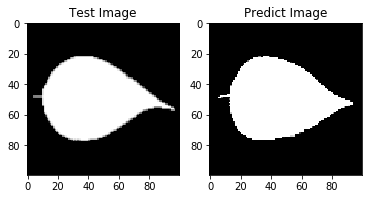

---
id = 526
label = Quercus_Rubra


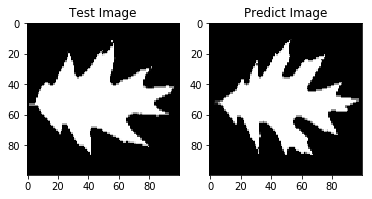

---
id = 1304
label = Lithocarpus_Cleistocarpus


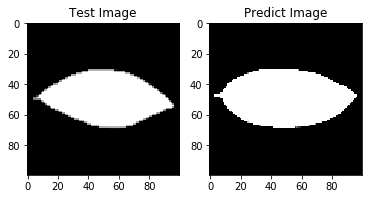

---
id = 102
label = Acer_Opalus


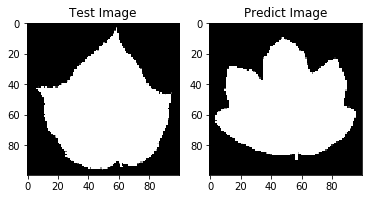

---
id = 1510
label = Alnus_Viridis


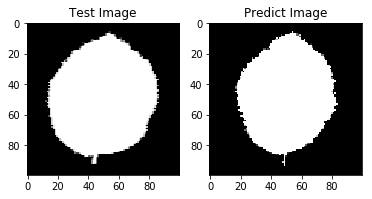

---
id = 1086
label = Quercus_Coccinea


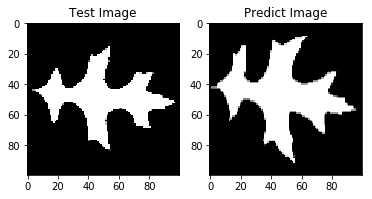

---
id = 687
label = Betula_Pendula


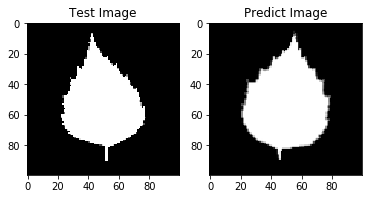

---
id = 274
label = Salix_Intergra


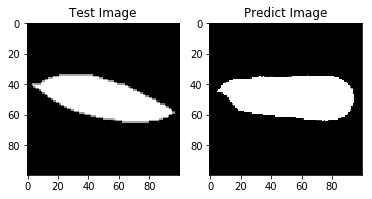

In [37]:
def show_png(label=''):
    x_id = train['id'].values
    x_species = train['species'].values
    x_classes_idx = np.array([x_id[i] for i, _ in enumerate(x_species) if _ == label])[0]
    img = Image.open('../input/images/{:.0f}.jpg'.format(x_classes_idx))
    
    return img

def predict_png(idx=0):
    t_id_test = test['id'].values
    t_idx = np.argmax(t_test[idx])
    t_label = classes[t_idx]
    t_id = t_id_test[idx]
    img = Image.open('../input/images/{:.0f}.jpg'.format(t_id))
    
    print('id = ' + str(t_id))
    print('label = ' + t_label)
    
    fig = plt.figure()
    ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)   
    ax1.imshow(resize_img_2d(np.array(img), end_size=100, show=True), 'gray')
    ax1.set_title('Test Image')    
    ax2.imshow(resize_img_2d(np.array(show_png(t_label)), end_size=100, show=True), 'gray')
    ax2.set_title('Predict Image') 
    
    plt.show()

for idx in np.random.choice(594, 10):
    print('---')
    predict_png(idx)

### submission

In [22]:
submission = pd.DataFrame()
submission['id'] = test['id']
for i, label in enumerate(label_species.keys()):
    submission[label] = t_test[:,i]

In [23]:
submission

,id,Acer_Opalus,Pterocarya_Stenoptera,Quercus_Hartwissiana,Tilia_Tomentosa,Quercus_Variabilis,Magnolia_Salicifolia,Quercus_Canariensis,Quercus_Rubra,Quercus_Brantii,...,Quercus_Ellipsoidalis,Quercus_x_Hispanica,Quercus_Shumardii,Quercus_Rhysophylla,Castanea_Sativa,Ulmus_Bergmanniana,Quercus_Nigra,Salix_Intergra,Quercus_Infectoria_sub,Sorbus_Aria
0,4,8.891323e-14,2.205897e-10,9.832791e-14,7.042201e-12,1.802532e-13,7.483725e-16,1.232528e-13,6.867614e-11,2.086902e-09,...,8.518744e-11,3.279733e-13,3.988299e-12,3.815517e-12,4.434006e-11,1.477799e-12,6.119149e-13,1.695243e-11,1.726228e-14,7.174851e-16
1,7,7.922653e-10,2.277957e-07,1.267927e-08,7.361725e-08,1.277407e-06,3.985756e-08,9.999965e-07,4.276510e-07,8.259635e-07,...,1.602369e-07,4.559838e-07,4.183428e-07,7.702557e-07,6.927912e-08,1.717344e-07,2.163786e-06,2.696133e-06,4.767460e-08,3.422853e-03
2,9,6.789936e-05,4.029709e-01,6.925547e-04,1.062052e-03,1.828150e-02,2.157672e-06,2.766838e-02,1.221453e-02,9.258168e-03,...,9.487188e-06,2.827276e-06,2.162772e-07,2.227296e-04,5.807696e-04,7.143109e-03,6.488138e-06,8.722292e-07,4.794099e-05,6.123512e-07
3,12,1.746454e-06,2.819163e-06,1.025245e-08,1.566148e-08,7.744942e-08,3.334732e-08,1.290551e-05,6.988943e-06,1.483384e-06,...,1.507061e-07,3.034428e-07,4.950180e-07,3.965476e-07,6.285218e-08,1.124305e-06,3.736008e-07,4.506824e-09,1.406290e-07,4.120015e-07
4,13,1.106033e-12,1.589277e-07,4.815854e-10,1.604702e-08,1.755647e-08,4.310007e-11,2.334145e-10,6.397472e-09,3.743922e-10,...,5.246514e-08,3.604408e-12,9.854003e-08,3.871113e-08,5.562451e-09,1.628890e-09,3.197952e-10,9.356951e-09,9.472905e-12,5.018668e-12
5,16,3.199521e-09,6.890482e-08,5.384614e-12,9.986504e-01,5.300956e-10,8.222532e-11,5.471681e-09,2.574554e-06,1.014392e-06,...,7.662289e-10,1.183476e-09,5.947936e-12,3.564987e-05,3.270459e-04,1.317153e-07,1.697703e-07,8.853605e-10,6.413298e-11,7.981608e-09
6,19,7.573855e-07,9.126169e-04,4.791054e-09,9.964888e-01,1.862030e-05,1.524063e-09,1.482695e-04,1.595213e-04,5.120027e-07,...,1.845620e-08,1.741188e-06,4.404101e-11,1.826636e-04,6.089433e-05,6.521896e-04,4.154896e-08,4.071233e-07,2.016209e-08,1.387481e-07
7,23,4.133627e-04,4.976875e-06,1.398990e-03,1.631704e-05,3.116463e-06,2.099850e-06,1.278801e-05,9.699672e-02,2.096464e-07,...,1.796123e-04,1.978210e-03,2.037985e-08,7.907208e-06,8.085449e-06,1.704002e-05,2.371656e-04,2.591249e-06,4.287905e-06,2.228310e-05
8,24,1.091756e-06,7.780443e-06,2.308480e-06,7.125967e-08,3.932778e-06,7.623409e-08,1.640296e-05,2.731573e-04,9.003626e-06,...,1.418030e-06,4.228505e-05,1.425915e-07,8.364512e-06,1.263829e-05,5.394214e-06,1.365448e-06,4.530069e-07,7.398588e-07,1.578743e-05
9,28,6.438869e-13,3.536245e-10,3.429861e-13,3.830062e-09,3.683415e-11,8.040270e-15,6.576858e-09,2.396795e-06,9.999976e-01,...,2.653355e-13,6.032107e-10,8.131932e-18,3.495872e-11,2.141194e-11,6.277192e-12,4.155829e-16,6.620470e-12,1.883658e-09,1.214390e-16


In [24]:
submission.to_csv('./submission_Conv2D-img-2.csv', index=False)